In [ ]:
# when the probability topic gains popularity, what has changed for the topic itself?

In [35]:
import logging
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus, textcorpus
import numpy as np
from gensim.matutils import hellinger
import time
import pickle
import pyLDAvis
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy
from scipy import stats

from IPython.core.debugger import set_trace

In [3]:
# load data
doc_year = [167,196,156,207,249,404,378,
271,
201,
768,
673,
823,
431,
681,
498,
597,
464,
657]

doc_ids =[0]+list(np.cumsum(doc_year))


alldata_new = pickle.load(open('output/20topics_newpreprocess_dict.p', 'rb'))
term_topic = alldata_new['term_topic']# term_topic is n_years*n_topics*n_terms
term_frequency = alldata_new['term_frequency']#term_frequency is n_years*n_terms
terms = alldata_new['terms']#terms is n_terms
doc_topicyrs = alldata_new['doc_topic']

doc_topic = []
doc_length=[]
for year in range(len(term_topic)):    
    doc_topic.append(alldata_new['doc_topic'][doc_ids[year]:doc_ids[year+1]])# doc_topic is nyear*n_docs given year*n_topics
    doc_length.append(alldata_new['doc_length'][doc_ids[year]:doc_ids[year+1]]) #doc_length is nyear*n_docs given year
    
# rename topics by their top freq word
topics = range(term_topic.shape[1])

def topic_label(topic, term_topic, terms):
    term_freqs = np.sum(term_topic[:,topic,:], axis = 0)
    max_term = np.argsort(-term_freqs)[0]
    return(terms[max_term])


topic_labels = [topic_label(topic, term_topic, terms) for topic in topics]
import pandas as pd

with open('output/all_visdtm.p','br') as f:
    allvisdtm=pickle.load(f)
for visdtm in allvisdtm:

    visdtm[0]['topiclabel']=topic_labels

In [4]:
[print(str(i)+topic_labels[i]) for i in range(len(topic_labels))]

0spatial
1face
2speaker
3action
4trial
5relational
6reasoning
7probability
8stimulus
9concept
10speech
11child
12category
13rule
14sentence
15movement
16causal
17network
18student
19decision


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

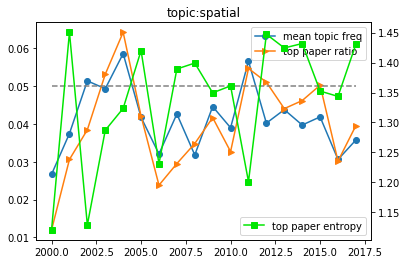

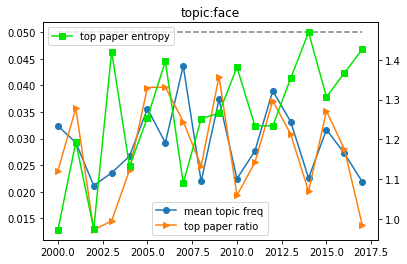

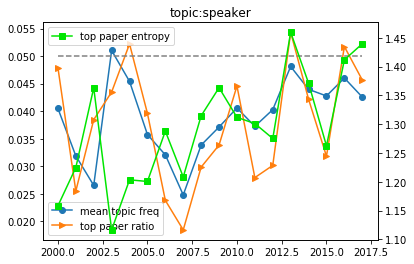

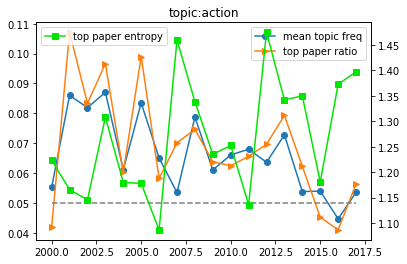

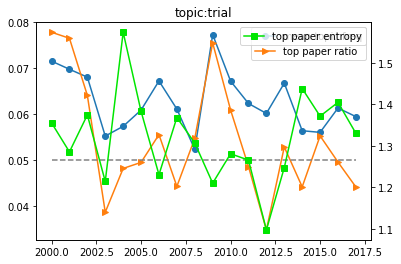

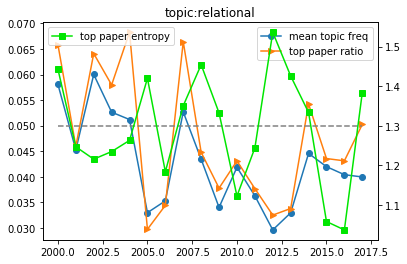

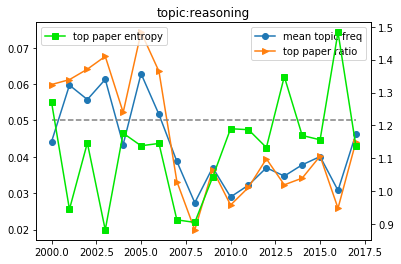

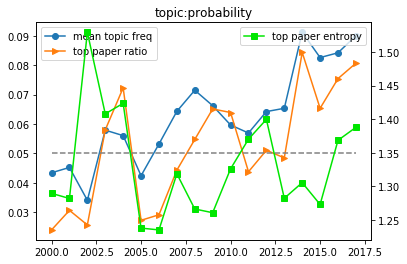

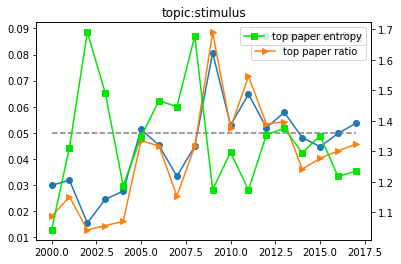

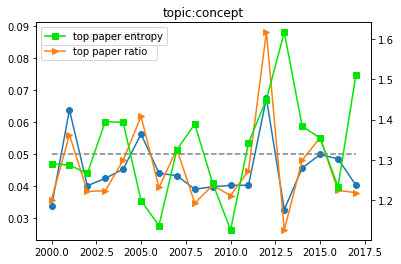

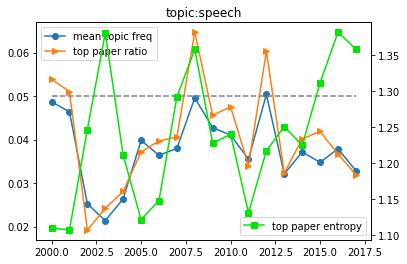

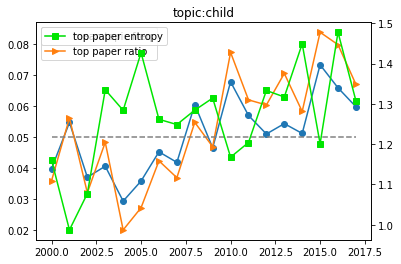

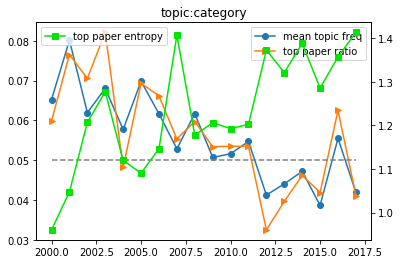

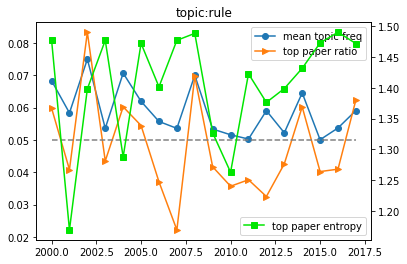

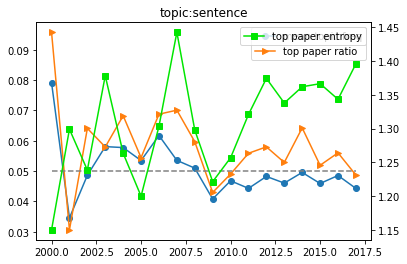

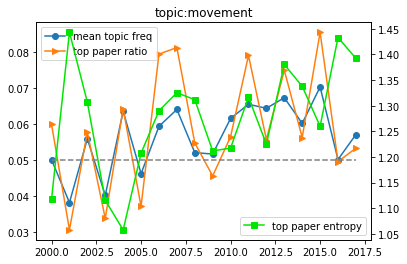

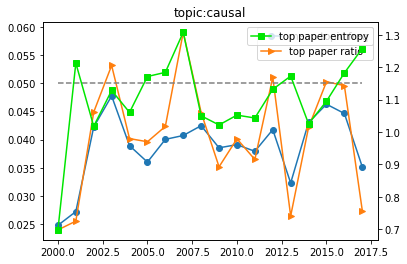

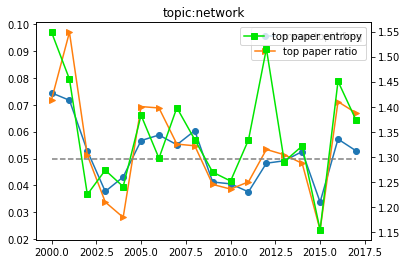

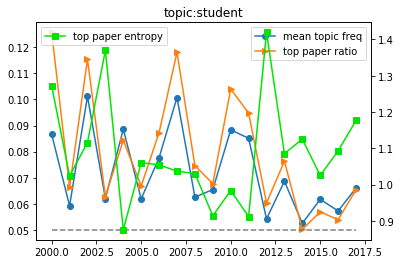

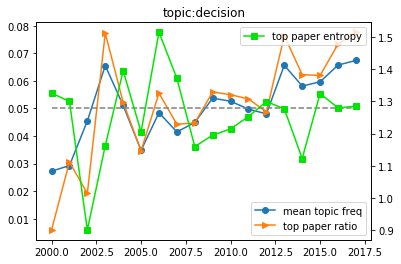

In [51]:
# 2 ways of characterize the trend: 1) proportion of papers counted as mainly probabilistic 2) mean freq of prob topics in each year
#ntop=7 # index for probability topic
alltopfreq=[]
allppratio=[]
allppen=[]
for ntop in range(20):
    paperratio=np.empty(len(term_topic))
    topfreq=np.empty(len(term_topic))
    ppen_years=np.empty(len(term_topic))
    for year in range(len(term_topic)):
        topfreq[year]=np.mean(doc_topic[year],axis=0)[ntop]
        paperratio[year]=sum(np.argmax(doc_topic[year],axis=1)==ntop)/len(doc_topic[year])
        ppentropy = []
        idx = np.where(np.argmax(doc_topic[year],axis=1)==ntop) 
        topicds=doc_topic[year][idx]
        for d in topicds:
            ppentropy.append(entropy(d))
        ppen_years[year]=np.mean(ppentropy)
    alltopfreq.append(topfreq)
    allppratio.append(paperratio)
    allppen.append(ppen_years)
    
    plt.plot(np.arange(len(term_topic))+2000,topfreq,'-o',label='mean topic freq')
    plt.plot(np.arange(len(term_topic))+2000,paperratio,'->',label='top paper ratio')
    plt.plot(np.arange(len(term_topic))+2000,np.ones_like(topfreq)*(1/20),'--',color=[.5,.5,.5])
    ax=plt.gca()
    ax.legend()
    ax2=ax.twinx()
    ax2.plot(np.arange(len(term_topic))+2000,ppen_years,'-s',color=[0,.9,0],label='top paper entropy')
    
    plt.title('topic:'+topic_labels[ntop])
    plt.legend()
    plt.show()

In [ ]:
# turns out most topics have similar amount for the 2 criteria, yet for probabilistic modeling, learning and memory ("trial"), problem solving("rule"), the paper ratio is significantly lower. 
# that indicates: many paper with other major topics still have a sizeble amount of stress on these topics.

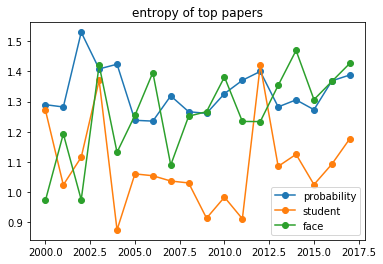

In [16]:
# analyze top papers' entropy and compare topics -- no clear conclusion. probability has been a mixed field always.
nface=1

nprob=7
ndecision=19

naction=3
nstud=18

for ntop in [nprob,nstud,nface]:
    ppen_years = allppen[ntop]
    plt.plot(np.arange(len(term_topic))+2000,ppen_years,'-o',label=topic_labels[ntop])
    plt.title('entropy of top papers')
plt.legend()
plt.show()

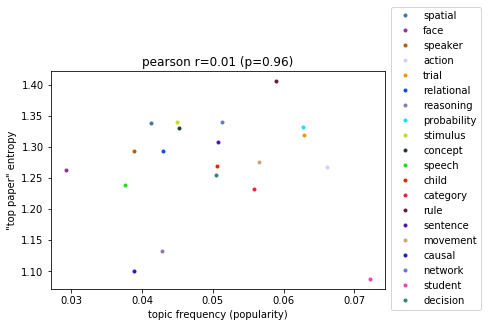

In [49]:
# top paper entropy and topic popularity: any relation? -- yes, sort of positive correlation. Though counter example exists
"""for ntop in range(len(topic_labels)):
    plt.plot(np.mean(allppratio[ntop]),np.mean(allppen[ntop]),'.')
plt.show()"""

avtopfreq= []
avppentro=[]
for ntop in range(len(topic_labels)):
    """    if ntop==nstud:
        continue
"""    
    avtopfreq.append(np.mean(alltopfreq[ntop]))
    avppentro.append(np.mean(allppen[ntop]))
    plt.plot(np.mean(alltopfreq[ntop]),np.mean(allppen[ntop]),'.',color=np.random.rand(3),label=topic_labels[ntop])

                     
r=stats.pearsonr(avtopfreq,avppentro)                     
plt.legend(loc='center right',bbox_to_anchor=(1.3, .6))
plt.title('pearson r=%.2f (p=%.2f)'%r)
plt.xlabel('topic frequency (popularity)')
plt.ylabel('"top paper" entropy')
                     
plt.show()


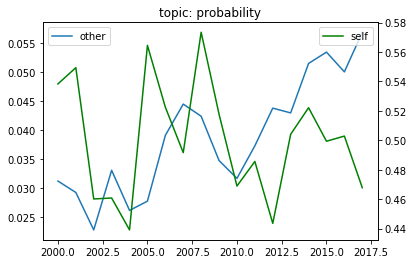

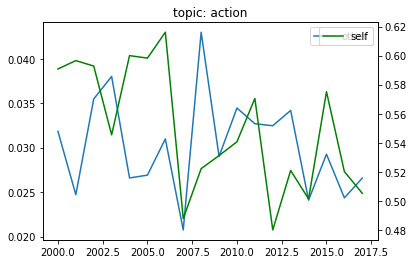

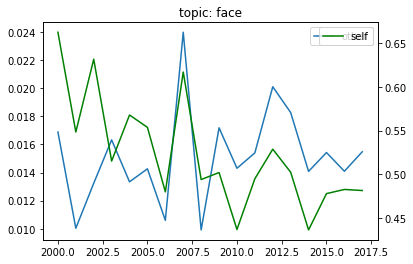

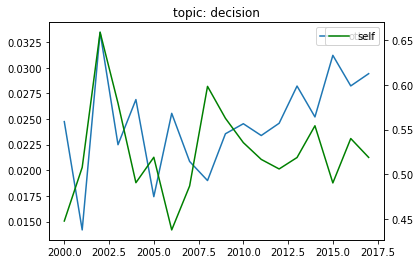

In [57]:
# how this topic has invaded other topics...not a useful analysis. if just frequency, it's like the same question. Plus unclear the self/other distinction is so useful...
for ntop in [nprob,naction,nface,ndecision]:
    freq_other=[]
    freq_self=[]
    for year in range(len(doc_year)):
        topfreq=[]
        topfreq_self=[]
        for thisdoc in doc_topic[year]:
            if np.argmax(thisdoc)!=ntop:
                topfreq.append(thisdoc[ntop])
            else:
                topfreq_self.append(thisdoc[ntop])
        freq_other.append(np.mean(topfreq))
        freq_self.append(np.mean(topfreq_self))
    plt.plot(np.arange(len(term_topic))+2000,freq_other,label='other')
    plt.title('topic: '+topic_labels[ntop])
    ax=plt.gca()
    ax.legend()
    ax2=ax.twinx()
    ax2.plot(np.arange(len(term_topic))+2000,freq_self,color='g',label='self')
    ax2.legend()

    plt.show()
    

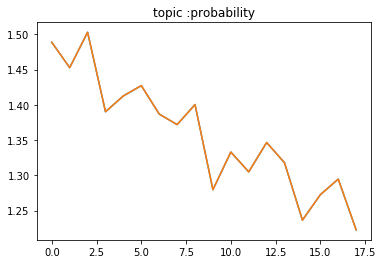

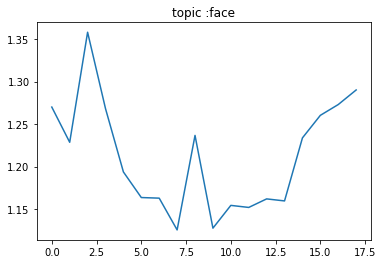

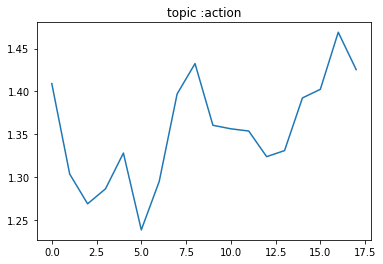

In [75]:
# topic content change during the rise of a topic: KLdiv with other topics are closer? maybe also in the t-sne space?
for ntop in [nprob,nface,naction]:
    topic_KL = []
    for year in range(len(term_topic)):
        ttop=term_topic[year]
        tfreq=term_frequency[year]/sum(term_frequency[year])
        topic_KL.append(entropy(tfreq,ttop[ntop]))
    plt.plot(topic_KL)
    plt.title('topic :'+topic_labels[ntop])
    plt.show()

In [70]:
len(ttop[ntop])

9710